In [10]:
%pip install mplcursors matplotlib numpy
%pip install pyyaml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message


In [12]:
BAG_PATH = "/home/aman/ros_ws/src/1_not_pkg/aman_test/data/eBot full run teleoped"    # folder, not .db3
SCAN_TOPIC = "/scan"
ODOM_TOPIC = "/odom"


In [13]:
def quaternion_to_yaw(q):
    siny = 2.0 * (q.w * q.z + q.x * q.y)
    cosy = 1.0 - 2.0 * (q.y * q.y + q.z * q.z)
    return math.atan2(siny, cosy)


In [14]:
reader = rosbag2_py.SequentialReader()
reader.open(
    rosbag2_py.StorageOptions(uri=BAG_PATH, storage_id="sqlite3"),
    rosbag2_py.ConverterOptions("cdr", "cdr"),
)

topic_types = {t.name: t.type for t in reader.get_all_topics_and_types()}
scan_type = get_message(topic_types[SCAN_TOPIC])
odom_type = get_message(topic_types[ODOM_TOPIC])

current_x = None
current_y = None
current_yaw = None

global_x = []
global_y = []

while reader.has_next():
    topic, data, _ = reader.read_next()

    if topic == ODOM_TOPIC:
        msg = deserialize_message(data, odom_type)
        current_x = msg.pose.pose.position.x
        current_y = msg.pose.pose.position.y
        current_yaw = quaternion_to_yaw(msg.pose.pose.orientation)

    elif topic == SCAN_TOPIC and current_x is not None:
        msg = deserialize_message(data, scan_type)

        ranges = np.array(msg.ranges)
        angles = msg.angle_min + np.arange(len(ranges)) * msg.angle_increment

        valid = np.isfinite(ranges)
        ranges = ranges[valid]
        angles = angles[valid]

        x_l = ranges * np.cos(angles)
        y_l = ranges * np.sin(angles)

        cy = math.cos(current_yaw)
        sy = math.sin(current_yaw)

        xg = current_x + (x_l * cy - y_l * sy)
        yg = current_y + (x_l * sy + y_l * cy)

        global_x.extend(xg)
        global_y.extend(yg)

print(f"Total points: {len(global_x)}")


[INFO] [1768032669.127766838] [rosbag2_storage]: Opened database '/home/aman/ros_ws/src/1_not_pkg/aman_test/data/eBot full run teleoped/rosbag2_2025_12_26-17_47_12_0.db3' for READ_ONLY.


Total points: 1665216


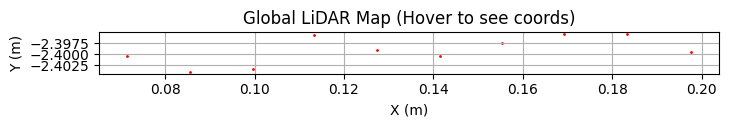

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter(global_x[:10], global_y[:10], s=1, c="red")

ax.set_title("Global LiDAR Map (Hover to see coords)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect("equal")
ax.grid(True)

cursor = mplcursors.cursor(sc, hover=True)

@cursor.connect("add")
def on_add(sel):
    x, y = sel.target
    sel.annotation.set_text(f"x={x:.3f}\ny={y:.3f}")

plt.show()
